In [262]:
import numpy as np
import networkx as nx
import random
import cvxpy as cp
import matplotlib.pyplot as plt
from pyomo.environ import *
# from torch_geometric.utils.convert import from_networkx
from collections import deque
from copy import deepcopy

In [263]:
# !pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
# !pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
# !pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
# !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
# !pip install torch-geometric
# !pip install torch-geometric-temporal
#!pip install pyomo

In [264]:
seed = 2
random.seed(2)

In [265]:
num_microservices = 10
num_edge_servers = 10

BLOCK_SIZE = 1 # For 1GB

microservice_graph = nx.DiGraph()

for m in range(num_microservices):
    microservice_graph.add_node(m, 
                                requested_cpu=random.randint(500, 2000), 
                                requested_memory=random.randint(512, 2048), 
                                requested_disk=random.randint(BLOCK_SIZE, 4*BLOCK_SIZE),
                                data_bw=random.randint(100, 1000)
            )

# Add edges ensuring no cycles (DAG)
possible_edges = [(i, j) for i in range(num_microservices) for j in range(i + 1, num_microservices)]
for _ in range(num_microservices * 2):  # Add twice the number of nodes as edges
    if not possible_edges:
        break
    m1, m2 = random.choice(possible_edges)
    possible_edges.remove((m1, m2))
    bandwidth = random.randint(100, 1000)
    microservice_graph.add_edge(m1, m2, bw_min=bandwidth)



In [266]:
edge_network = nx.erdos_renyi_graph(num_edge_servers, 0.7, seed=seed, directed=False)

for n in range(num_edge_servers):
    # Update node attr
    edge_network.add_node(n, 
                          available_cpu=random.randint(4000, 8000), 
                          available_memory=random.randint(4096, 4 * 4096), 
                          available_disk=random.randint(4*BLOCK_SIZE, 16*BLOCK_SIZE),
                          cpu_frequency=random.randint(1000, 3000),
                          energy_per_cpu_unit=random.random() / 10
                        )

for n1, n2 in edge_network.edges():
    # n1, n2 = random.sample(range(num_edge_servers), 2)
    # Update edge attr
    bandwidth = random.randint(1000, 2000)
    edge_network.add_edge(n1, n2, bw=bandwidth, reverse_bw=1/bandwidth)

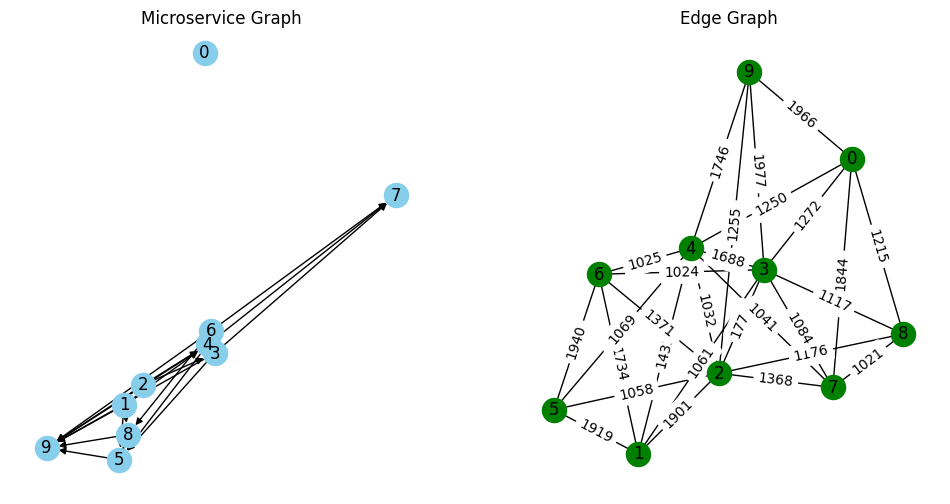

In [267]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
nx.draw(microservice_graph, with_labels=True, node_color='skyblue')
plt.title("Microservice Graph")

plt.subplot(1, 2, 2)
pos = nx.spring_layout(edge_network)
nx.draw(edge_network, pos, with_labels=True, node_color='green')
edge_attr = nx.get_edge_attributes(edge_network, 'bw')
nx.draw_networkx_edge_labels(edge_network, pos, edge_labels=edge_attr)
plt.title("Edge Graph")

plt.show()

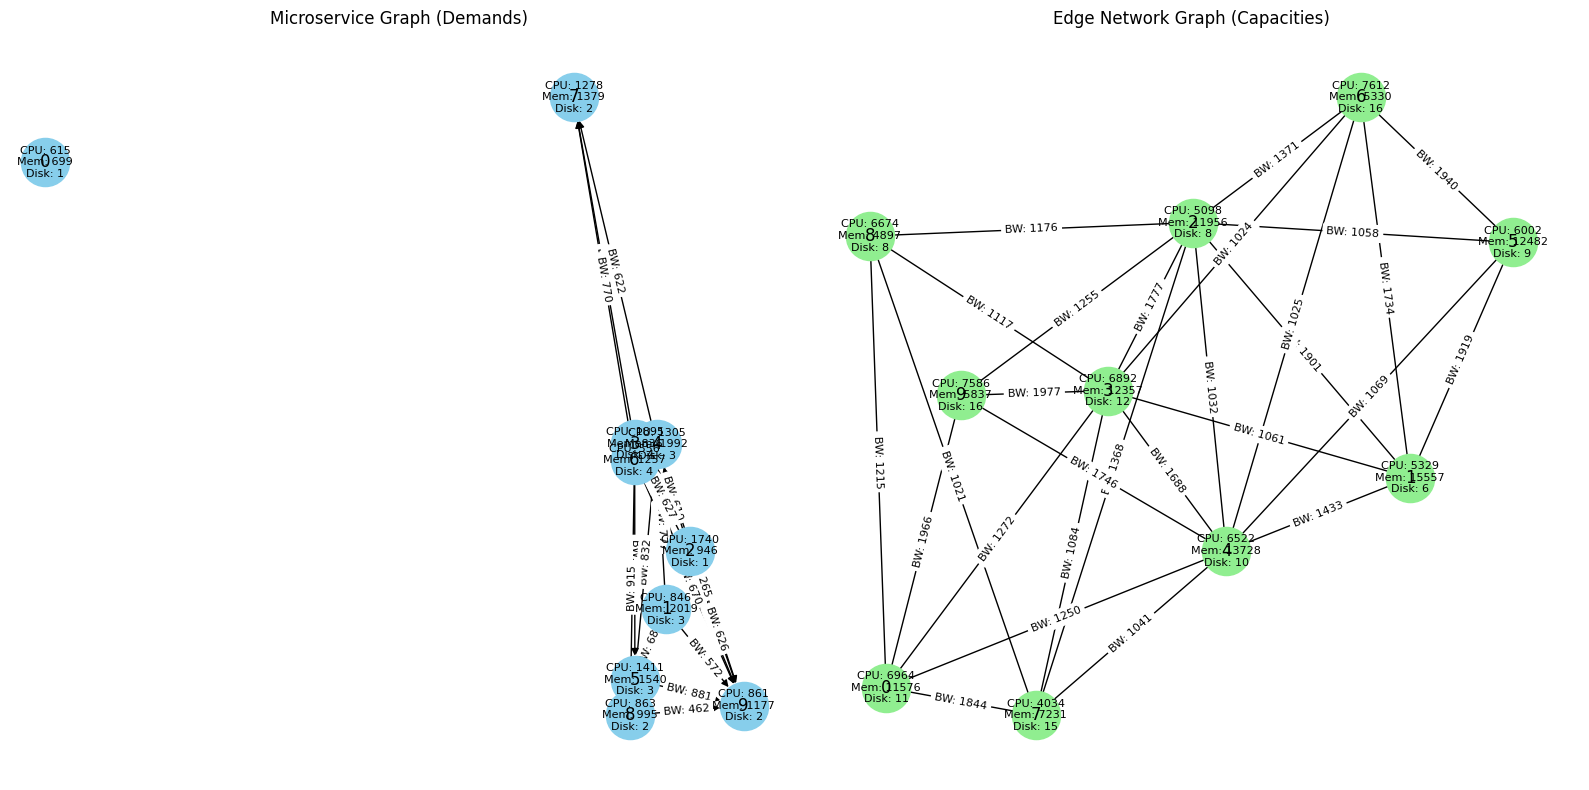

In [268]:
# Plotting Microservice Graph
plt.figure(figsize=(16, 8))

# Microservice Graph
plt.subplot(1, 2, 1)
pos_ms = nx.spring_layout(microservice_graph)
nx.draw(microservice_graph, pos_ms, with_labels=True, node_color='skyblue', node_size=1200)
labels_ms = {node: f"CPU: {microservice_graph.nodes[node]['requested_cpu']}\nMem: {microservice_graph.nodes[node]['requested_memory']}\nDisk: {microservice_graph.nodes[node]['requested_disk']}" for node in microservice_graph.nodes}
nx.draw_networkx_labels(microservice_graph, pos_ms, labels=labels_ms, font_size=8)

edge_labels_ms = {(u, v): f"BW: {data['bw_min']}" for u, v, data in microservice_graph.edges(data=True)}
nx.draw_networkx_edge_labels(microservice_graph, pos_ms, edge_labels=edge_labels_ms, font_size=8)
plt.title("Microservice Graph (Demands)")

# Edge Network Graph
plt.subplot(1, 2, 2)
pos_edge = nx.spring_layout(edge_network)
nx.draw(edge_network, pos_edge, with_labels=True, node_color='lightgreen', node_size=1200)
labels_edge = {node: f"CPU: {edge_network.nodes[node]['available_cpu']}\nMem: {edge_network.nodes[node]['available_memory']}\nDisk: {edge_network.nodes[node]['available_disk']}" for node in edge_network.nodes}
nx.draw_networkx_labels(edge_network, pos_edge, labels=labels_edge, font_size=8)

edge_labels_edge = {(u, v): f"BW: {data['bw']}" for u, v, data in edge_network.edges(data=True)}
nx.draw_networkx_edge_labels(edge_network, pos_edge, edge_labels=edge_labels_edge, font_size=8)
plt.title("Edge Network Graph (Capacities)")

plt.tight_layout()
plt.show()


In [269]:
def find_k_hop_neighbors(graph, node, k):
    """
    Find the k-hop neighbors of a given node in the graph.

    :param graph: A NetworkX graph
    :param node: Node for which to find neighbors
    :param k: Number of hops
    :return: A list of k-hop neighbors sorted by path cost
    """
    # Find k-hop neighbors
    neighbors = set(
        n for n, dist in nx.single_source_shortest_path_length(graph, node).items() if dist == k
    )

    # Calculate path costs for each neighbor
    neighbor_cost_pairs = []
    for neighbor in neighbors:
        path_cost = nx.shortest_path_length(graph, source=node, target=neighbor, weight='reverse_bw')
        neighbor_cost_pairs.append((neighbor, path_cost))

    # Sort neighbors by path cost
    sorted_neighbors = sorted(neighbor_cost_pairs, key=lambda x: x[1])

    # Extract and return only the sorted neighbors (without costs)
    return [neighbor for neighbor, cost in sorted_neighbors]

In [270]:
class EdgeNetworkOptimization:
    def __init__(self, microservice_graph, edge_network):
        self.microservice_graph = microservice_graph
        self.edge_network = edge_network

        self.num_microservices = len(self.microservice_graph.nodes)
        self.num_edge_servers = len(self.edge_network.nodes)

    def get_num_microservices(self):
        return self.num_microservices

    def get_num_edge_servers(self):
        return self.num_edge_servers
        
    def compute_placement_cost(self, x, y, verbose=False):
            # print(x.shape)
            x = (x >= np.max(x, axis=1).reshape(-1, 1).repeat(self.num_edge_servers, axis=1)).astype(int)
            # print(x)
            L_ms = 0
            L_energy = 0
            L_vol = 0

            for m1, m2 in self.microservice_graph.edges():
                cpu_demands_m1 = self.microservice_graph.nodes[m1]["requested_cpu"]
                cpu_demands_m2 = self.microservice_graph.nodes[m2]["requested_cpu"]
                min_bw = self.microservice_graph.edges[(m1, m2)]["bw_min"]
                for n1 in range(self.num_edge_servers):
                    for n2 in range(self.num_edge_servers):
                        path_cost = 0
                        if x[m1, n1] * x[m2, n2] > 0:
                            if n1 != n2:
                                try:
                                    path = nx.shortest_path(self.edge_network, source=n1, target=n2, weight='reverse_bw')
                                    # path_cost = sum(1 / self.edge_network[u][v]['bw'] for u, v in zip(path[:-1], path[1:]))
                                    # path_cost = nx.shortest_path_length(self.edge_network, source=n1 - 1, target=n2 - 1, weight='reverse_bw')
                                    for (u, v) in zip(path[:-1], path[1:]):
                                        # path_cost += min_bw / (self.edge_network.edges[(u, v)]['bw'] + 0.0001)
                                        path_cost += min_bw / self.edge_network.edges[(u, v)]['bw']
                                        # self.edge_network.edges[(u, v)]['bw'] = max(0.1, self.edge_network.edges[(u, v)]['bw'] - min_bw)
                                        # self.edge_network.edges[(u, v)]['reverse_bw'] = 1 / self.edge_network.edges[(u, v)]['bw']
                                except:
                                    pass
                        
                        computation_cost = x[m1, n1] * cpu_demands_m1 / self.edge_network.nodes[n1]["cpu_frequency"] + x[m2, n2] * cpu_demands_m2 / self.edge_network.nodes[n2]["cpu_frequency"]
                        energy_cost = x[m1, n1] * self.edge_network.nodes[n1]["energy_per_cpu_unit"] * cpu_demands_m1 + x[m2, n2] * self.edge_network.nodes[n2]["energy_per_cpu_unit"] * cpu_demands_m2
                        # min_bw_cost = max(0, (x[m1, n1] * x[m2, n2] * min_bw - bw_uv) ** 2)
                        # path_cost =  min_bw / (bw_uv + 0.0001)
                        communication_cost = x[m1, n1] * x[m2, n2] * path_cost
                        # L_ms += data['bw_min'] * x[m1, n1] * x[m2, n2] * path_cost
                        L_ms += communication_cost + computation_cost
                        L_energy += energy_cost
            

            for m in range(self.num_microservices):
                data_bw = self.microservice_graph.nodes[m]["data_bw"]
                for n1 in range(self.num_edge_servers):
                    for n2 in range(self.num_edge_servers):
                        path_cost = 0
                        if n1 != n2:
                            try:
                                path = nx.shortest_path(self.edge_network, source=n1, target=n2, weight='reverse_bw')
                                for (u, v) in zip(path[:-1], path[1:]):
                                    # path_cost += min_bw / (self.edge_network.edges[(u, v)]['bw'] + 0.0001)
                                    path_cost += data_bw / self.edge_network.edges[(u, v)]['bw']
                                    # self.edge_network.edges[(u, v)]['bw'] = max(0.1, self.edge_network.edges[(u, v)]['bw'] - data_bw)
                                    # self.edge_network.edges[(u, v)]['reverse_bw'] = 1 / self.edge_network.edges[(u, v)]['bw']
                            except:
                                pass
                        L_vol += x[m, n1] * y[m, n2] * path_cost


            constraint_violations = 0

            # Placement constraint: Each microservice must be assigned to one edge server
            for m in range(self.num_microservices):
                if np.sum(x[m, :]) != 1:
                    print("Placement constraint violation")
                    constraint_violations += 1

            # Resource constraints per edge server
            for n in range(self.num_edge_servers):
                cpu_usage = sum(x[m, n] * self.microservice_graph.nodes[m]['requested_cpu'] for m in range(self.num_microservices))
                memory_usage = sum(x[m, n] * self.microservice_graph.nodes[m]['requested_memory'] for m in range(self.num_microservices))
                disk_usage = sum(y[m, n] for m in range(self.num_microservices))

                if cpu_usage > self.edge_network.nodes[n]['available_cpu']:
                    print("CPU violation")
                    constraint_violations += 1
                if memory_usage > self.edge_network.nodes[n]['available_memory']:
                    print("Memory violation")
                    
                    constraint_violations += 1
                if disk_usage > self.edge_network.nodes[n]['available_disk']:
                    print(f"Disk violation {disk_usage}, available: {self.edge_network.nodes[n]['available_disk']}")
                    
                    constraint_violations += 1

            # Disk demand constraint
            for m in range(self.num_microservices):
                if np.sum(y[m, :]) != self.microservice_graph.nodes[m]['requested_disk']:
                    print(f"Disk demand constraint violation: allocated: {np.sum(y[m, :])} requested {self.microservice_graph.nodes[m]['requested_disk']}")
                    
                    constraint_violations += 1

            penalty = 10000 * constraint_violations
            if verbose:
                print(f"MS placement cost: {L_ms}, Energy cost {L_energy} , Data placement cost: {L_vol}, Penalty: {penalty}")

            return L_ms + L_energy + L_vol + penalty


In [271]:
sim = EdgeNetworkOptimization(microservice_graph, edge_network)

## Exact method (using Gurobi solver)

In [272]:
class ExactSolver:
    def __init__(self, sim):
        self.sim = sim
        
        self.microservice_graph = self.sim.microservice_graph
        self.edge_network = self.sim.edge_network

        self.num_microservices = len(self.microservice_graph.nodes)
        self.num_edge_servers = len(self.edge_network.nodes)

    def solve(self):
        model = ConcreteModel()
        model.microservices = RangeSet(1, self.num_microservices)  # 1-based indexing
        model.edge_servers = RangeSet(1, self.num_edge_servers)  # 1-based indexing

        # Variables
        model.x = Var(model.microservices, model.edge_servers, domain=Binary)
        model.y = Var(model.microservices, model.edge_servers, domain=NonNegativeIntegers)
        

        def cost(model):
            L_ms = 0
            L_vol = 0
            L_energy = 0

            for m1, m2, data in self.microservice_graph.edges(data=True):
                cpu_demands_m1 = self.microservice_graph.nodes[m1]["requested_cpu"]
                cpu_demands_m2 = self.microservice_graph.nodes[m2]["requested_cpu"]
                min_bw = self.microservice_graph.edges[(m1, m2)]["bw_min"]
                for n1 in model.edge_servers:
                    for n2 in model.edge_servers:
                        path_cost = 0
                        # bw_uv = 0
                        if n1 != n2:
                            # Shortest paths can be precomputed in order to reduce time complexity
                            # Howver it would increase space complexity
                            try:
                                path = nx.shortest_path(self.edge_network, source=n1 - 1, target=n2 - 1, weight='reverse_bw')
                                # path_cost = sum(1 / self.edge_network[u][v]['bw'] for u, v in zip(path[:-1], path[1:]))
                                # path_cost = nx.shortest_path_length(self.edge_network, source=n1 - 1, target=n2 - 1, weight='reverse_bw')
                                for (u, v) in zip(path[:-1], path[1:]):
                                    # path_cost += min_bw / (self.edge_network.edges[(u, v)]['bw'] + 0.0001)
                                    # print(self.edge_network.edges[(u, v)]['bw'])
                                    path_cost += min_bw / self.edge_network.edges[(u, v)]['bw']
                                    # self.edge_network.edges[(u, v)]['bw'] = max(0.1, self.edge_network.edges[(u, v)]['bw'] - min_bw)
                                    # self.edge_network.edges[(u, v)]['reverse_bw'] = 1 / self.edge_network.edges[(u, v)]['bw']
                                    # print(self.edge_network.edges[(u, v)]['bw'])
                                    
                            except:
                                # path_cost += model.x[m1 + 1, n1] * model.x[m2 + 1, n2] * 1000
                                pass
                        
                        computation_cost = model.x[m1 + 1, n1] * cpu_demands_m1 / self.edge_network.nodes[n1-1]["cpu_frequency"] + model.x[m2 + 1, n2] * cpu_demands_m2 / self.edge_network.nodes[n2-1]["cpu_frequency"]
                        
                        energy_cost = model.x[m1 + 1, n1] * self.edge_network.nodes[n1-1]["energy_per_cpu_unit"] * cpu_demands_m1 + model.x[m2 + 1, n2] * self.edge_network.nodes[n2-1]["energy_per_cpu_unit"] * cpu_demands_m2
                        communication_cost = model.x[m1 + 1, n1] * model.x[m2 + 1, n2] * path_cost
                        L_ms +=  communication_cost + computation_cost
                        L_energy += energy_cost
                        
            for m in model.microservices:
                data_bw = self.microservice_graph.nodes[m - 1]["data_bw"]
                for n1 in model.edge_servers:
                    for n2 in model.edge_servers:
                        path_cost = 0
                        path = None
                        if n1 != n2:
                            try:
                                path = nx.shortest_path(self.edge_network, source=n1-1, target=n2-1, weight='reverse_bw')
                                for (u, v) in zip(path[:-1], path[1:]):
                                    # path_cost += min_bw / (self.edge_network.edges[(u, v)]['bw'] + 0.0001)
                                    path_cost += data_bw / self.edge_network.edges[(u, v)]['bw']
                                    # self.edge_network.edges[(u, v)]['bw'] = max(0.1, self.edge_network.edges[(u, v)]['bw'] - data_bw)
                                    # self.edge_network.edges[(u, v)]['reverse_bw'] = 1 / self.edge_network.edges[(u, v)]['bw']
                            except:
                                path_cost = 0
                            
                        L_vol += model.x[m, n1] * model.y[m, n2] * path_cost
            # print(L_ms+L_vol)
            return L_ms + L_vol + L_energy

        model.objective = Objective(rule=cost, sense=minimize)

        # Constraints
        def placement_constraint(model, m):
            return sum(model.x[m, n] for n in model.edge_servers) == 1

        def resource_constraint_cpu(model, n):
            return sum(model.x[m, n] * self.microservice_graph.nodes[m - 1]['requested_cpu'] for m in model.microservices) <= self.edge_network.nodes[n - 1]['available_cpu']

        def resource_constraint_memory(model, n):
            return sum(model.x[m, n] * self.microservice_graph.nodes[m - 1]['requested_memory'] for m in model.microservices) <= self.edge_network.nodes[n - 1]['available_memory']

        def disk_constraint(model, n):
            return sum(model.y[m, n] for m in model.microservices) <= self.edge_network.nodes[n - 1]['available_disk']

        def disk_demand_constraint(model, m):
            return sum(model.y[m, n] for n in model.edge_servers) == self.microservice_graph.nodes[m - 1]['requested_disk']
        
        # def non_negativity_constraint(model, m1, m2, n1, n2):
        #     return model.z[m1, m2, n1, n2] >= 1
        
        # def bandwidth_capacity_constraint(model, n1, n2):
        #     if n1 != n2:
        #         try:
        #             return sum(model.z[m1 + 1, m2 + 1, n1, n2] for m1, m2 in self.microservice_graph.edges()) <= self.edge_network.edges[(n1 - 1, n2 - 1)]['bw']
        #         except:
        #             return Constraint.Skip
                    
        #     else:
        #         return Constraint.Skip
        
        # def min_bandwidth_constraint(model, m1, m2):
        #     c = True
        #     if m1 != m2:
        #         for n1 in model.edge_servers:
        #             for n2 in model.edge_servers:
        #                 if n1 != n2:
        #                     try:
        #                         path = nx.shortest_path(self.edge_network, source=n1 - 1, target=n2 - 1, weight='reverse_bw')
        #                         for (u, v) in zip(path[:-1], path[1:]):
        #                             c = c and self.edge_network.edges[(u, v)]['bw'] >= self.microservice_graph.edges[(m1-1, m2-1)] and model.x[m1, n1] > 0 and model.x[m2, n1]
        #                     except:
        #                         pass
        #         return Constraint.Feasible if c else Constraint.Infeasible
        #     else:
        #         return Constraint.Skip


        model.placement_constraints = Constraint(model.microservices, rule=placement_constraint)
        model.cpu_constraints = Constraint(model.edge_servers, rule=resource_constraint_cpu)
        model.memory_constraints = Constraint(model.edge_servers, rule=resource_constraint_memory)
        model.disk_constraints = Constraint(model.edge_servers, rule=disk_constraint)
        model.disk_demand_constraints = Constraint(model.microservices, rule=disk_demand_constraint)
        
        # model.non_negativity_constraints = Constraint(model.microservices, model.microservices, model.edge_servers, model.edge_servers, rule=non_negativity_constraint)
        # model.bandwidth_capacity_constraints = Constraint(model.edge_servers, model.edge_servers, rule=bandwidth_capacity_constraint)
        # model.min_bandwidth_constraints = Constraint(model.microservices, model.microservices, rule=min_bandwidth_constraint)
        
        # Solve the model usnig Gurobi solver
        solver = SolverFactory('gurobi')
        result = solver.solve(model, tee=True)

        if result.solver.status == SolverStatus.ok and result.solver.termination_condition == TerminationCondition.optimal:
            print("Optimization successful!", value(model.objective))
            placement = [[model.x[m, n].value for n in model.edge_servers] for m in model.microservices]
            disk_alloc = [[model.y[m, n].value for n in model.edge_servers] for m in model.microservices]
            #bw_alloc = [[model.z[m1, m2, n1, n2].value for n1, n2 in zip(model.edge_servers, model.edge_servers)] for m1, m2 in zip(model.microservices, model.microservices)]
            # bw_alloc = np.zeros((self.num_microservices, self.num_microservices, self.num_edge_servers, self.num_edge_servers))
    
            # for m1 in model.microservices:
            #     for m2 in model.microservices:
            #         for n1 in model.edge_servers:
            #             for n2 in model.edge_servers:
            #                 bw_alloc[m1 - 1, m2 - 1, n1 - 1, n2 - 1] = model.z[m1, m2, n1, n2].value
            #                 print(model.z[m1, m2, n1, n2].value)
            return np.array(placement), np.array(disk_alloc)
        else:
            print("Optimization failed:", result.solver.status)
            return None, None

In [273]:
exact_solver = ExactSolver(sim=sim)


In [274]:
%%time
ms_placement, disk_placement = exact_solver.solve()

Read LP format model from file /tmp/tmpg7fob9gg.pyomo.lp
Reading time = 0.00 seconds
x1: 50 rows, 200 columns, 500 nonzeros
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Fedora Linux 39 (Workstation Edition)")

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Academic license 2618838 - for non-commercial use only - registered to mo___@uqtr.ca
Optimize a model with 50 rows, 200 columns and 500 nonzeros
Model fingerprint: 0xe69b4748
Model has 2700 quadratic objective terms
Variable types: 0 continuous, 200 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [1e+02, 9e+03]
  QObjective range [1e-01, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+04]
Found heuristic solution: objective 20231.146225
Presolve removed 10 rows and 0 columns
Presolve time: 0.02s
Presolved: 2740 rows, 2900 columns, 85

In [275]:
ms_placement

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0., -0.,  0., -0.],
       [-0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -0., -0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  1.],
       [-0.,  0.,  0.,  0.,  0.,  0., -0.,  1., -0., -0.],
       [-0.,  0.,  0.,  0.,  0.,  0.,  0., -0., -0.,  1.],
       [-0.,  0.,  0.,  0.,  0.,  0.,  0., -0., -0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]])

In [276]:
disk_placement

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-0., -0., -0., -0., -0., -0., -0.,  3., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0.,  1.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0.,  4.],
       [-0., -0., -0., -0., -0., -0., -0.,  3., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0.,  3.],
       [-0., -0., -0., -0., -0., -0., -0.,  4., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0.,  2.],
       [-0., -0., -0.,  1., -0., -0., -0., -0., -0.,  1.],
       [-0., -0., -0., -0., -0., -0., -0.,  2., -0., -0.]])

In [277]:
sim.compute_placement_cost(ms_placement, disk_placement, verbose=True)

MS placement cost: 304.98469749746926, Energy cost 5074.482939405025 , Data placement cost: 0.06272129489124936, Penalty: 0


5379.530358197385

## GA for ms placement with simple heuristic for data placement

In [193]:
class GASolver:
    def __init__(self, sim, population_size=50, generations=100, mutation_rate=0.1, crossover_rate=0.8):
        self.sim = sim
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.num_microservices = sim.get_num_microservices()
        self.num_edge_servers = sim.get_num_edge_servers()
    
    def initialize_population(self):
        return [np.random.randint(0, self.num_edge_servers, self.num_microservices) for _ in range(self.population_size)]

    def fitness(self, chromosome):
        x = np.zeros((self.num_microservices, self.num_edge_servers))
        for m, n in enumerate(chromosome):
            x[m, n] = 1

        # TODO: Use heuristic for data allocation
        y = self.allocate_data(x)

        # compute cost
        cost = self.compute_cost(x, y)

        return cost

    def allocate_data(self, x):
        y = np.zeros((self.num_microservices, self.num_edge_servers))
        edge_network = deepcopy(self.sim.edge_network)
        for ms in self.sim.microservice_graph.nodes:
            disk_demand = self.sim.microservice_graph.nodes[ms]['requested_disk']
            placed_on = x.argmax(axis=1)[ms]
            k = 0
            while k < 5 and disk_demand > 0: # TODO: To be changed (k)
                k_hop_neighbors = find_k_hop_neighbors(sim.edge_network, placed_on, k)
                for neighbor in k_hop_neighbors:
                    available = edge_network.nodes[neighbor]['available_disk']
                    if disk_demand > 0 and available > 0:
                        if disk_demand <= available:
                            allocation = disk_demand
                            disk_demand = 0
                        else:
                            allocation = available
                            disk_demand -= allocation
                        
                        edge_network.nodes[neighbor]['available_disk'] -= allocation
                        y[ms, neighbor] = allocation
                k += 1
        return y

    def compute_cost(self, x, y):
        return self.sim.compute_placement_cost(x, y)


    def crossover(self, parent1, parent2):
        if np.random.rand() < self.crossover_rate:
            point = np.random.randint(1, self.num_microservices - 1)
            child1 = np.concatenate((parent1[:point], parent2[point:]))
            child2 = np.concatenate((parent2[:point], parent1[point:]))
            return child1, child2
        return parent1, parent2

    def mutate(self, chromosome):
        if np.random.rand() < self.mutation_rate:
            m = np.random.randint(self.num_microservices)
            chromosome[m] = np.random.randint(self.num_edge_servers)
        return chromosome

    def solve(self):
        population = self.initialize_population()
        best_solution = None
        best_fitness = float('inf')
        best_fitness_hist = deque(maxlen=5)
    
        for generation in range(self.generations):
            fitness_scores = [self.fitness(chromosome) for chromosome in population]
            fitness_scores = np.array(fitness_scores)

            # Get sorted indices
            sorted_indices = np.argsort(fitness_scores)

            # Sort the population by fitness from lowest cost to highest cost
            sorted_population = [population[i] for i in sorted_indices]
            
            best_solution = sorted_population[0]
            best_fitness = min(fitness_scores)
    
            # Prepare the next generation
            next_generation = []
    
            while len(next_generation) < self.population_size:
                # Select parents
                parent1 = self.tournament_selection(population, fitness_scores)
                parent2 = self.tournament_selection(population, fitness_scores)
    
                # Crossover
                child1, child2 = self.crossover(parent1, parent2)
    
                # Mutate
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)
    
                # Add offspring to the next generation
                next_generation.extend([child1, child2])
    
            # Update the population
            population = next_generation[:self.population_size]
            print(f"Generation {generation+1}: Best Fitness = {best_fitness}")
            
            best_fitness_hist.append(best_fitness)
            if len(best_fitness_hist) == 3 and len(set(best_fitness_hist)) == 1:
                break

        x = np.zeros((self.num_microservices, self.num_edge_servers))
        for m, n in enumerate(best_solution):
            x[m, n] = 1
        return x, self.allocate_data(x)

        
    def tournament_selection(self, population, fitness_scores, tournament_size=3):
        """Select a parent using tournament selection."""
        participants = np.random.choice(len(population), tournament_size, replace=False)
        best_participant = min(participants, key=lambda i: fitness_scores[i])
        return population[best_participant]


In [194]:
ga_solver = GASolver(sim=sim, population_size=20, generations=20)

In [195]:
%%time
ms_placement_ga, disk_placement_ga = ga_solver.solve()

CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
Memory violation
Generation 1: Best Fitness = 290466.1819160751
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
Generation 2: Best Fitness = 281382.27715886594
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
Memory violation
CPU violation
Generation 3: Best Fitness = 270921.81056983455
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
CPU violati

In [196]:
sim.compute_placement_cost(ms_placement_ga, disk_placement_ga, verbose=True)

CPU violation
MS placement cost: 183980.0, Energy cost 54604.47278129593 , Data placement cost: 2810.0, Penalty: 10000


251394.47278129595

## PSO solver

In [115]:
class PSOSolver:
    def __init__(self, sim, num_particles=50, generations=100, w=0.5, c1=1.5, c2=1.5):
        """
        Initialize the PSO solver.

        :param sim: Simulation object
        :param num_particles: Number of particles in the swarm
        :param generations: Number of iterations
        :param w: Inertia weight
        :param c1: Cognitive parameter (local best influence)
        :param c2: Social parameter (global best influence)
        """
        self.sim = sim
        self.num_particles = num_particles
        self.generations = generations
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.num_microservices = sim.get_num_microservices()
        self.num_edge_servers = sim.get_num_edge_servers()

    def initialize_particles(self):
        """
        Initialize the particles' positions and velocities.
        """
        positions = np.random.randint(0, self.num_edge_servers, (self.num_particles, self.num_microservices))
        velocities = np.random.uniform(-1, 1, (self.num_particles, self.num_microservices))
        return positions, velocities

    def fitness(self, particle):
        """
        Compute the fitness of a particle.
        """
        x = np.zeros((self.num_microservices, self.num_edge_servers))
        for m, n in enumerate(particle):
            x[m, n] = 1

        y = self.allocate_data(x)
        cost = self.compute_cost(x, y)
        return cost

    def allocate_data(self, x):
        """
        Allocate data using the heuristic.
        """
        y = np.zeros((self.num_microservices, self.num_edge_servers))
        edge_network = deepcopy(self.sim.edge_network)
        for ms in self.sim.microservice_graph.nodes:
            disk_demand = self.sim.microservice_graph.nodes[ms]['requested_disk']
            placed_on = x.argmax(axis=1)[ms]
            k = 0
            while k < 5 and disk_demand > 0:  # TODO: To be changed (k)
                k_hop_neighbors = find_k_hop_neighbors(self.sim.edge_network, placed_on, k)
                for neighbor in k_hop_neighbors:
                    available = edge_network.nodes[neighbor]['available_disk']
                    if disk_demand > 0 and available > 0:
                        if disk_demand <= available:
                            allocation = disk_demand
                            disk_demand = 0
                        else:
                            allocation = available
                            disk_demand -= allocation

                        edge_network.nodes[neighbor]['available_disk'] -= allocation
                        y[ms, neighbor] = allocation
                k += 1
        return y

    def compute_cost(self, x, y):
        """
        Compute the cost of a solution.
        """
        return self.sim.compute_placement_cost(x, y)

    def solve(self):
        """
        Run the PSO algorithm.
        """
        # Initialize particles
        positions, velocities = self.initialize_particles()
        personal_best_positions = positions.copy()
        personal_best_scores = np.array([self.fitness(p) for p in positions])
        global_best_position = personal_best_positions[np.argmin(personal_best_scores)]
        global_best_score = np.min(personal_best_scores)

        best_fitness_hist = deque(maxlen=5)

        for generation in range(self.generations):
            for i in range(self.num_particles):
                # Update velocity
                r1, r2 = np.random.rand(2)
                velocities[i] = (
                    self.w * velocities[i]
                    + self.c1 * r1 * (personal_best_positions[i] - positions[i])
                    + self.c2 * r2 * (global_best_position - positions[i])
                )

                # Update position
                positions[i] = np.clip(positions[i] + velocities[i], 0, self.num_edge_servers - 1).astype(int)

                # Evaluate fitness
                fitness_score = self.fitness(positions[i])

                # Update personal best
                if fitness_score < personal_best_scores[i]:
                    personal_best_scores[i] = fitness_score
                    personal_best_positions[i] = positions[i]

                # Update global best
                if fitness_score < global_best_score:
                    global_best_score = fitness_score
                    global_best_position = positions[i]

            print(f"Generation {generation + 1}: Best Fitness = {global_best_score}")

            # Early stopping condition
            best_fitness_hist.append(global_best_score)
            if len(best_fitness_hist) == 3 and len(set(best_fitness_hist)) == 1:
                break

        # Return the best solution
        x = np.zeros((self.num_microservices, self.num_edge_servers))
        for m, n in enumerate(global_best_position):
            x[m, n] = 1
        return x, self.allocate_data(x)

In [116]:
pso_solver = PSOSolver(sim, num_particles=20, generations=20, w=0.5, c1=1.5, c2=1.5)


In [117]:
%%time
x, y = pso_solver.solve()

CPU violation
CPU violation
Generation 1: Best Fitness = 137699.68593609333
CPU violation
CPU violation
CPU violation
Generation 2: Best Fitness = 119451.52076961112
CPU violation
CPU violation
CPU violation
CPU violation
CPU violation
Generation 3: Best Fitness = 118135.45518810289
CPU violation
CPU violation
Generation 4: Best Fitness = 118135.45518810289
CPU violation
Generation 5: Best Fitness = 118135.45518810289
CPU violation
Generation 6: Best Fitness = 118135.45518810289
CPU violation
Generation 7: Best Fitness = 118135.45518810289
Generation 8: Best Fitness = 118135.45518810289
Generation 9: Best Fitness = 118135.45518810289
Generation 10: Best Fitness = 111675.95484265451
Generation 11: Best Fitness = 111675.95484265451
Generation 12: Best Fitness = 111675.95484265451
CPU violation
Generation 13: Best Fitness = 111675.95484265451
Generation 14: Best Fitness = 111675.95484265451
Generation 15: Best Fitness = 111675.95484265451
Generation 16: Best Fitness = 111675.95484265451
G

In [85]:
x, y

(array([[0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]]),
 array([[0., 0., 0., 0., 3.],
        [0., 0., 0., 0., 3.],
        [0., 0., 0., 0., 3.],
        [0., 0., 0., 0., 4.],
        [0., 0., 0., 0., 3.]]))

In [86]:
sim.compute_placement_cost(x, y, verbose=True)

CPU violation
Memory violation
MS placement cost: 0, Energy cost 8150.947030260737 , Data placement cost: 0.0, Penalty: 20000


28150.947030260737

In [120]:
dict1 = dict(microservice_graph.degree(weight='bw_min'))
dict1

{0: 1280,
 1: 2772,
 2: 958,
 3: 3130,
 4: 1346,
 5: 1946,
 6: 4646,
 7: 2799,
 8: 2270,
 9: 2939}

In [121]:
dict2 = nx.degree_centrality(microservice_graph)
dict2

{0: 0.3333333333333333,
 1: 0.5555555555555556,
 2: 0.1111111111111111,
 3: 0.5555555555555556,
 4: 0.3333333333333333,
 5: 0.3333333333333333,
 6: 0.6666666666666666,
 7: 0.4444444444444444,
 8: 0.5555555555555556,
 9: 0.5555555555555556}

In [119]:
list(microservice_graph.neighbors(0))

[3, 8, 6]

## Heuristic

In [278]:
class GraphCentralityHeuristic:
    cloud_resources = {'available_disk': float('inf')}  # Cloud has virtually infinite disk space
    CLOUD_NODE = 'cloud'
    
    def __init__(self, sim):
        self.sim = sim
        
        self.microservice_graph = self.sim.microservice_graph
        self.edge_network = self.sim.edge_network

        self.num_microservices = len(self.microservice_graph.nodes)
        self.num_edge_servers = len(self.edge_network.nodes)
    
    def solve(self):
        edge_network = deepcopy(self.sim.edge_network)
        
        # For each microservice, we calculate node degree centrality
        ms_centrality = nx.degree_centrality(microservice_graph)
        ms_weighted_degrees = dict(microservice_graph.degree(weight='bw_min'))
        # ms_centrality = {key: ms_centrality[key] * ms_weighted_degrees[key] for key in ms_centrality}
        sorted_ms = sorted(ms_centrality, key=lambda k: -ms_centrality[k])

        server_centrality = nx.degree_centrality(edge_network)
        server_weighted_degrees = dict(edge_network.degree(weight='bw'))
        server_centrality = {key: server_centrality[key] * server_weighted_degrees[key] for key in server_centrality}
        sorted_servers = sorted(server_centrality, key=lambda k: -server_centrality[k])

        ms_placement = np.zeros((len(sorted_ms), len(sorted_servers) ))
        data_placement = np.zeros((len(sorted_ms), len(sorted_servers) ))
        
        for ms in sorted_ms:
            # print(ms)
            # Filter edges based on the resources, ie edge servers that can't accomodate the ms are filtered out
            cpu_demand, memory_demand, disk_demand = microservice_graph.nodes[ms]['requested_cpu'], microservice_graph.nodes[ms]['requested_memory'], microservice_graph.nodes[ms]['requested_disk']
            candidate_edge_servers = []
            # Filter
            for edge_node, edge_attr in edge_network.nodes(data=True):
                available_cpu, available_memory = edge_attr['available_cpu'], edge_attr['available_memory']
                if available_cpu > cpu_demand and available_memory > memory_demand:
                    candidate_edge_servers.append(edge_node)
            # 
        
            if len(candidate_edge_servers) == 0:
                print('No candidate edge server was found')
                break
            
            
            # Score based on energy consumption
            energy_scores = {}
            for candidate in candidate_edge_servers:
                # energy_scores[candidate] = -edge_network.nodes[candidate]["energy_per_cpu_unit"] * cpu_demand
                energy_scores[candidate] = -edge_network.nodes[candidate]["energy_per_cpu_unit"] * cpu_demand

            
            highest_score = -np.inf
            highest_candidate = None
            for candidate in candidate_edge_servers:
                score = server_centrality[candidate] + energy_scores[candidate]
                if score >= highest_score:
                    highest_score = score
                    highest_candidate = candidate
            
            ms_placement[ms, highest_candidate] = 1
            
            # Update resources
            edge_network.nodes[highest_candidate]['available_cpu'] -= cpu_demand
            edge_network.nodes[highest_candidate]['available_memory'] -= memory_demand
            
            # Update bandwidth information
            # for neighbor in microservice_graph.neighbors(ms):
            #     bw_min = microservice_graph.edges[ms, neighbor]['bw_min']
            #     # Check if the neighbor is placed
            #     if ms_placement[neighbor, :].sum() > 0:
            #         neighbor_server = ms_placement[neighbor, :].argmax()
            #         path = nx.shortest_path(edge_network, source=highest_candidate, target=neighbor_server, weight='reverse_bw')
            #         for u, v in zip(path[:-1], path[1:]):
            #             edge_network.edges[(u, v)]['bw'] = max(0.1, self.edge_network.edges[(u, v)]['bw'] - bw_min)
            #             edge_network.edges[(u, v)]['reverse_bw'] = 1 / self.edge_network.edges[(u, v)]['bw']
            
            # server_centrality = nx.degree_centrality(edge_network)
            # server_weighted_degrees = dict(edge_network.degree(weight='bw'))
            # server_centrality = {key: server_centrality[key] * server_weighted_degrees[key] for key in server_centrality}
            # sorted_servers = sorted(server_centrality, key=lambda k: -server_centrality[k])

            
        # Data placement
        # Sort microservices by data bandwidth
        bw_sorted_ms = sorted(microservice_graph.nodes, key=lambda k: -microservice_graph.nodes[k]['data_bw'])
        
        
        for ms in bw_sorted_ms:
            disk_demand = self.sim.microservice_graph.nodes[ms]['requested_disk']
            placed_on = ms_placement.argmax(axis=1)[ms]
            k = 0
            while k < 10 and disk_demand > 0: # TODO: To be changed (k)
                k_hop_neighbors = find_k_hop_neighbors(edge_network, placed_on, k)
                # Sort k hop neighbors by bandwith
                k_hop_neighbors = sorted(k_hop_neighbors, key=lambda x: -server_centrality[x])
                
                for neighbor in k_hop_neighbors:
                    available = edge_network.nodes[neighbor]['available_disk']
                    if disk_demand > 0 and available > 0:
                        if disk_demand <= available:
                            allocation = disk_demand
                            disk_demand = 0
                        else:
                            allocation = available
                            disk_demand -= allocation
                        
                        edge_network.nodes[neighbor]['available_disk'] -= allocation
                        data_placement[ms, neighbor] = allocation
                #         path = nx.shortest_path(edge_network, source=placed_on, target=neighbor, weight='reverse_bw')
                #         for u, v in zip(path[:-1], path[1:]):
                #             edge_network.edges[(u, v)]['bw'] = max(0.1, self.edge_network.edges[(u, v)]['bw'] - allocation / data_bw)
                #             edge_network.edges[(u, v)]['reverse_bw'] = 1 / self.edge_network.edges[(u, v)]['bw']
                
                # server_centrality = nx.degree_centrality(edge_network)
                # server_weighted_degrees = dict(edge_network.degree(weight='bw'))
                # server_centrality = {key: server_centrality[key] * server_weighted_degrees[key] for key in server_centrality}
                # sorted_servers = sorted(server_centrality, key=lambda k: -server_centrality[k])
                
                k += 1
        return ms_placement, data_placement


In [279]:
my_solver = GraphCentralityHeuristic(sim=sim)


In [280]:
%%time
ms_placement_mine, disk_placement_mine = my_solver.solve()

CPU times: user 14.5 ms, sys: 1.9 ms, total: 16.4 ms
Wall time: 15.5 ms


In [281]:
ms_placement_mine, disk_placement_mine

(array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 2., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 4., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 3., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 3., 0., 0., 0., 0., 0.],
        [0., 0., 0., 4., 0., 0., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 2., 0., 0., 0., 0., 0.],
        [0., 0., 2., 0., 0., 0., 0., 0., 0., 0.]

In [282]:
sim.compute_placement_cost(ms_placement_mine, disk_placement_mine, verbose=True)

MS placement cost: 252.76914409657311, Energy cost 29952.979416228893 , Data placement cost: 1.1528097108008837, Penalty: 0


30206.901370036267

In [283]:
# Algorithm based on node ranks
class GraphCentralityRankBasedHeuristic:

    def __init__(self, sim):
        self.sim = sim
        
        self.microservice_graph = self.sim.microservice_graph
        self.edge_network = self.sim.edge_network

        self.num_microservices = len(self.microservice_graph.nodes)
        self.num_edge_servers = len(self.edge_network.nodes)

        self.ms_centrality = nx.degree_centrality(microservice_graph)
        self.ms_weighted_degrees = dict(microservice_graph.degree(weight='bw_min'))

        self.rank_cache = {}
        
    def _get_candidate_server(self, ms, edge_network):
        cpu_demand, memory_demand = microservice_graph.nodes[ms]['requested_cpu'], microservice_graph.nodes[ms]['requested_memory']
        candidate_edge_servers = []
        for edge_node, edge_attr in edge_network.nodes(data=True):
            available_cpu, available_memory = edge_attr['available_cpu'], edge_attr['available_memory']
            if available_cpu > cpu_demand and available_memory > memory_demand:
                candidate_edge_servers.append(edge_node)
        
        return candidate_edge_servers
    def _calculate_computation_cost(self, ms, edge_network):
        # Compute average computation cost on the available edge servers
        # Filter the edge servers based on the available resources
        candidate_edge_servers = self._get_candidate_server(ms, edge_network)
        # If no candidate edge server was found, return 0
        if len(candidate_edge_servers) == 0:
            return 0
        cpu_demand = microservice_graph.nodes[ms]['requested_cpu']
        avg = 0
        for candidate in candidate_edge_servers:
            avg += sum([cpu_demand / self.edge_network.nodes[candidate]["cpu_frequency"]])
        avg /= len(candidate_edge_servers)
        return avg
    
    def _calculate_communication_cost(self, m1, m2, edge_network):
        # Compute average communication cost between two microservices
        min_bw = self.microservice_graph.edges[(m1, m2)]['bw_min']
        candidate_edge_servers1 = self._get_candidate_server(m1, edge_network)
        candidate_edge_servers2 = self._get_candidate_server(m2, edge_network)
        if len(candidate_edge_servers1) == 0 or len(candidate_edge_servers2) == 0:
            return 0
        
        avg = 0
        for c1 in candidate_edge_servers1:
            for c2 in candidate_edge_servers2:
                path_cost = 0
                try:
                    path = nx.shortest_path(self.edge_network, source=c1, target=c2, weight='reverse_bw')
                    for u, v in zip(path[:-1], path[1:]):
                        path_cost += min_bw / self.edge_network.edges[(u, v)]['bw']
                except:
                    pass

                avg += path_cost
        avg /= len(candidate_edge_servers1) * len(candidate_edge_servers2)
        return avg
    def _calculate_rank(self, ms, edge_network):
        # If rank is already computed, return it from cache
        if ms in self.rank_cache:
            return self.rank_cache[ms]

        # Compute computation cost for the current microservice
        computation_cost = self._calculate_computation_cost(ms, edge_network)

        # Initialize max_neighbor_rank to 0
        max_neighbor_rank = 0

        # Iterate over all neighbors of the current microservice
        for neighbor in self.microservice_graph.neighbors(ms):
            # Recursively calculate the rank of the neighbor
            neighbor_rank = self._calculate_rank(neighbor, edge_network)
            # Calculate communication cost between current microservice and neighbor
            communication_cost = self._calculate_communication_cost(ms, neighbor, edge_network)
            # Update max_neighbor_rank
            max_neighbor_rank = max(max_neighbor_rank, neighbor_rank + communication_cost)

        # Calculate the rank of the current microservice
        rank = computation_cost + max_neighbor_rank + self.ms_centrality[ms]

        # Cache the computed rank
        self.rank_cache[ms] = rank

        return rank
    def solve(self):
        ms_placement = np.zeros((self.num_microservices, self.num_edge_servers))
        data_placement = np.zeros((self.num_microservices, self.num_edge_servers))

        edge_network = deepcopy(self.edge_network)
        
        # Calculate node degree centrality for microservice graph
        # ms_centrality = nx.degree_centrality(microservice_graph)
        # ms_weighted_degrees = dict(microservice_graph.degree(weight='bw_min'))
        server_centrality = nx.degree_centrality(edge_network)
        server_weighted_degrees = dict(edge_network.degree(weight='bw'))
        # server_centrality = {key: server_centrality[key] * server_weighted_degrees[key] for key in server_centrality}
        # sorted_servers = sorted(server_centrality, key=lambda k: -server_centrality[k])
        # Recursively calculate microservice graph nodes ranks using
        # rank(m) = computation_cost(m) + max(rank(n) + communication_cost(m, n) where n is a neighbor of m)
        ranks = {}
        for ms in self.microservice_graph.nodes:
            ranks[ms] = self._calculate_rank(ms, edge_network)
        
        # Sort microservices based on rank
        sorted_ms = sorted(ranks, key=lambda k: -ranks[k])
        for ms in sorted_ms:
            cpu_demand = microservice_graph.nodes[ms]['requested_cpu']
            memory_demand = microservice_graph.nodes[ms]['requested_memory']
            candidate_edge_servers = self._get_candidate_server(ms, edge_network)
            if len(candidate_edge_servers) == 0:
                print('No candidate edge server was found')
                break
            # Score based on energy consumption
            energy_scores = {}
            for candidate in candidate_edge_servers:
                energy_scores[candidate] = -edge_network.nodes[candidate]["energy_per_cpu_unit"] * cpu_demand

            
            highest_score = -np.inf
            highest_candidate = None
            print(f"Microservice {ms}")
            for candidate in candidate_edge_servers:
                score = server_centrality[candidate] + energy_scores[candidate]
                print(f"Candidate {candidate}: {score}")
                if score >= highest_score:
                    highest_score = score
                    highest_candidate = candidate
            
            ms_placement[ms, highest_candidate] = 1
            
            # Update resources
            edge_network.nodes[highest_candidate]['available_cpu'] -= cpu_demand
            edge_network.nodes[highest_candidate]['available_memory'] -= memory_demand
        
        
        # Data placement
        # Sort microservices by data bandwidth
        bw_sorted_ms = sorted(microservice_graph.nodes, key=lambda k: -microservice_graph.nodes[k]['data_bw'])
        for ms in bw_sorted_ms:
            disk_demand = self.sim.microservice_graph.nodes[ms]['requested_disk']
            placed_on = ms_placement.argmax(axis=1)[ms]
            k = 0
            while k < 10 and disk_demand > 0: # TODO: To be changed (k)
                k_hop_neighbors = find_k_hop_neighbors(edge_network, placed_on, k)
                # Sort k hop neighbors by bandwith
                k_hop_neighbors = sorted(k_hop_neighbors, key=lambda x: -server_centrality[x])
                
                for neighbor in k_hop_neighbors:
                    available = edge_network.nodes[neighbor]['available_disk']
                    if disk_demand > 0 and available > 0:
                        if disk_demand <= available:
                            allocation = disk_demand
                            disk_demand = 0
                        else:
                            allocation = available
                            disk_demand -= allocation
                        
                        edge_network.nodes[neighbor]['available_disk'] -= allocation
                        data_placement[ms, neighbor] = allocation
                k += 1
        return ms_placement, data_placement

In [284]:
solver = GraphCentralityRankBasedHeuristic(sim=sim)

In [285]:
%%time
ms_placement, disk_placement = solver.solve()

Microservice 2
Candidate 0: -38.03956035688034
Candidate 1: -157.4260908573849
Candidate 2: -165.69204892188262
Candidate 3: -87.39117573376741
Candidate 4: -126.29290943629519
Candidate 5: -118.61189264724082
Candidate 6: -58.85829688512334
Candidate 7: -9.66849241781054
Candidate 8: -38.98683164414433
Candidate 9: -23.306537382532117
Microservice 3
Candidate 0: -41.477631027241
Candidate 1: -171.49916855508937
Candidate 2: -180.53115545100306
Candidate 3: -95.25520447888908
Candidate 4: -137.62232250549263
Candidate 5: -129.2174858939139
Candidate 6: -64.15091017725278
Candidate 7: -10.579255311989705
Candidate 8: -42.49938784743816
Candidate 9: -25.422285763670832
Microservice 1
Candidate 0: -18.20965597428396
Candidate 1: -76.25621045901204
Candidate 2: -80.10391190876209
Candidate 3: -42.033487358678485
Candidate 4: -60.94777857266613
Candidate 5: -57.44156772771977
Candidate 6: -28.331869251809007
Candidate 8: -18.72731392966251
Candidate 9: -11.103446719706227
Microservice 4
Can

In [286]:
ms_placement, disk_placement

(array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 3.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 4., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 3.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 3.],
        [4., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [2., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [2., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [2., 0., 0., 0., 0., 0., 0., 0., 0., 0.]

In [287]:
sim.compute_placement_cost(ms_placement, disk_placement, verbose=True)

MS placement cost: 278.3858495323254, Energy cost 6680.129330171564 , Data placement cost: 0.0, Penalty: 0


6958.51517970389

## Algorithm based on topological sorting

In [690]:
class TopologicalSortingHeuristic:
    cloud_resources = {'available_disk': float('inf')}  # Cloud has virtually infinite disk space
    CLOUD_NODE = 'cloud'
    
    def __init__(self, sim):
        self.sim = sim
        
        self.microservice_graph = self.sim.microservice_graph
        self.edge_network = self.sim.edge_network

        self.num_microservices = len(self.microservice_graph.nodes)
        self.num_edge_servers = len(self.edge_network.nodes)
    
    def solve(self):
        edge_network = deepcopy(self.sim.edge_network)
        
        sorted_ms = list(nx.topological_sort(microservice_graph))
        server_degree_centrality = nx.degree_centrality(edge_network)
        sorted_servers = sorted(server_degree_centrality, key=lambda k: -server_degree_centrality[k])
        ms_placement = np.zeros((len(sorted_ms), len(sorted_servers) ))
        data_placement = np.zeros((len(sorted_ms), len(sorted_servers) ))
        
        for ms in sorted_ms:
            # print(ms)
            # Filter edges based on the resources, ie edge servers that can't accomodate the ms are filtered out
            cpu_demand, memory_demand, disk_demand = microservice_graph.nodes[ms]['requested_cpu'], microservice_graph.nodes[ms]['requested_memory'], microservice_graph.nodes[ms]['requested_disk']
            candidate_edge_servers = []
            # Filter
            for edge_node, edge_attr in edge_network.nodes(data=True):
                available_cpu, available_memory = edge_attr['available_cpu'], edge_attr['available_memory']
                if available_cpu > cpu_demand and available_memory > memory_demand:
                    candidate_edge_servers.append(edge_node)
        
            if len(candidate_edge_servers) == 0:
                print('No candidate edge server was found')
                break
            
            # Score based on energy consumption
            energy_scores = {}
            for candidate in candidate_edge_servers:
                # energy_scores[candidate] = -edge_network.nodes[candidate]["energy_per_cpu_unit"] * cpu_demand
                energy_scores[candidate] = -edge_network.nodes[candidate]["energy_per_cpu_unit"] * cpu_demand

            
            highest_score = -np.inf
            highest_candidate = None
            for candidate in candidate_edge_servers:
                score = 0.5 * server_degree_centrality[candidate] + 0.5 * energy_scores[candidate]
                if score >= highest_score:
                    highest_score = 0.5 * server_degree_centrality[candidate] + 0.5 * energy_scores[candidate]
                    highest_candidate = candidate
            
            ms_placement[ms, highest_candidate] = 1
            
            # Update resources
            edge_network.nodes[highest_candidate]['available_cpu'] -= cpu_demand
            edge_network.nodes[highest_candidate]['available_memory'] -= memory_demand
        
            
        # Data placement
        for ms in self.sim.microservice_graph.nodes:
            disk_demand = self.sim.microservice_graph.nodes[ms]['requested_disk']
            placed_on = ms_placement.argmax(axis=1)[ms]
            k = 0
            while k < 5 and disk_demand > 0: # TODO: To be changed (k)
                k_hop_neighbors = find_k_hop_neighbors(edge_network, placed_on, k)
                for neighbor in k_hop_neighbors:
                    available = edge_network.nodes[neighbor]['available_disk']
                    if disk_demand > 0 and available > 0:
                        if disk_demand <= available:
                            allocation = disk_demand
                            disk_demand = 0
                        else:
                            allocation = available
                            disk_demand -= allocation
                        
                        edge_network.nodes[neighbor]['available_disk'] -= allocation
                        data_placement[ms, neighbor] = allocation
                k += 1
        return ms_placement, data_placement


In [691]:

top_sort_solver = TopologicalSortingHeuristic(sim=sim)


In [692]:
%%time
x, y = top_sort_solver.solve()

CPU times: user 68.9 ms, sys: 5.81 ms, total: 74.7 ms
Wall time: 71.7 ms


In [693]:

sim.compute_placement_cost(x, y, verbose=True)

MS placement cost: 57.32681185530755, Energy cost 222800.78381430526 , Data placement cost: 0.018095970015276144, Penalty: 0


222858.12872213058

In [100]:
d = microservice_graph.degree(weight='bw_min')

In [101]:
d

DiDegreeView({0: 76, 1: 423, 2: 432, 3: 124, 4: 160, 5: 130, 6: 261, 7: 240, 8: 234, 9: 276})

In [103]:
dict(d)

{0: 76, 1: 423, 2: 432, 3: 124, 4: 160, 5: 130, 6: 261, 7: 240, 8: 234, 9: 276}

In [130]:
ms_degree = dict( microservice_graph.degree(weight='bw_min'))
# sorted_ms = sorted(ms_degree_centrality, key=lambda k: -ms_degree_centrality[k])
sorted_ms = sorted(ms_degree, key=lambda k: -ms_degree[k])
sorted_ms

[2, 1, 9, 6, 7, 8, 4, 5, 3, 0]

In [40]:
path = [0, 3, 1, 2]
for (u, v) in zip(path[:-1], path[1:]):
    print(f"Edge from {u} to {v}")

Edge from 0 to 3
Edge from 3 to 1
Edge from 1 to 2


In [42]:
edge_network.edges[(0, 1)]

{'bw': 260, 'reverse_bw': 0.0038461538461538464}